### AGH Modelling of Physical Systems Lab 6 (2025 April 8th)
Jakub Mieszczak (jmieszczak@student.agh.edu.pl)



In [1]:
"""notebook code targetting 100% `nbqa pylint` score! :)"""

from dataclasses import dataclass, field
from functools import cached_property
import numpy as np
import scipy.stats

from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

In [2]:
@dataclass
class DomainConfig:
    """
    Defines the physical simulation grid.
    """
    size: np.ndarray = field(default_factory=lambda: np.array([1000, 1000]))
    divisions: np.ndarray = field(default_factory=lambda: np.array([50, 50]))

    @cached_property
    def resolution(self) -> np.ndarray:
        """
        Returns grid resolution (cell width/height).
        """
        return self.size / self.divisions


@dataclass(frozen=True)
class SimulationClock:
    """
    Timing configuration for simulation loop.
    """
    total_duration: float = 300
    frame_count: int = 30
    flow_vector: np.ndarray = field(default_factory=lambda: np.array([1.5, -0.5]))

    @cached_property
    def time_step(self) -> float:
        """
        Time between simulation frames.
        """
        return self.total_duration / self.frame_count


def evaluate_courant_vector(
    clock: SimulationClock,
    domain: DomainConfig
) -> np.ndarray:
    """
    Computes the Courant number components per dimension.
    """
    return (clock.flow_vector / domain.resolution) * clock.time_step

@dataclass(frozen=True)
class ParticleSettings:
    """
    Settings defining the initial particle cloud.
    """
    count: int = 10_000
    magnitude: float = 1e10
    location: np.ndarray = field(default_factory=lambda: np.array([300.0, 200.0]))
    dispersion: np.ndarray = field(
        default_factory=lambda: np.array([[2000.0, 0.0], [0.0, 3000.0]])
    )

    @cached_property
    def gaussian(self) -> scipy.stats.multivariate_normal:
        """
        Returns a multivariate Gaussian representing the cloud.
        """
        return scipy.stats.multivariate_normal(mean=self.location, cov=self.dispersion)

    def extract_axis_distribution(self, axis_index: int = 0) -> scipy.stats.norm:
        """
        Returns a 1D normal distribution for a selected axis.
        """
        if not (0 <= axis_index < self.location.size):
            raise IndexError(f"Axis {axis_index} is out of bounds")

        mean_val = self.location[axis_index]
        std_dev = np.sqrt(self.dispersion[axis_index, axis_index])
        return scipy.stats.norm(loc=mean_val, scale=std_dev)

    def quantile_position(self, quantile: float, axis_index: int = 0) -> float:
        """
        Returns position along the given axis at the specified quantile.
        """
        return self.extract_axis_distribution(axis_index).ppf(quantile)


PARTICLE_DEF = ParticleSettings()
GRID_DEF = DomainConfig()
TIME_DEF = SimulationClock()
CFL_VECTOR = evaluate_courant_vector(TIME_DEF, GRID_DEF)
SEED_GEN = np.random.default_rng(seed=44)

In [3]:
@dataclass
class ParticleState:
    """
    Represents particles mapped to a simulation grid.
    """
    indices: np.ndarray = field(default_factory=lambda: np.zeros((0, 2), dtype=int))
    weights: np.ndarray = field(default_factory=lambda: np.zeros(0, dtype=int))
    coordinates: np.ndarray = field(default_factory=lambda: np.zeros((0, 2), dtype=float))


def generate_particles(
    *,
    config: ParticleSettings,
    domain: DomainConfig,
    generator: np.random.Generator,
) -> dict[str, ParticleState]:
    """
    Generates a particle set using two sampling approaches: uniform and distribution-based.
    """
    unit_random = generator.uniform(0.0, 1.0, size=(config.count, 2))

    transformed_coords = np.column_stack([
        config.quantile_position(unit_random[:, 0], axis_index=0),
        config.quantile_position(unit_random[:, 1], axis_index=1),
    ])

    return {
        label: ParticleState(
            indices=np.floor(data["coordinates"] / domain.resolution).astype(int),
            weights=np.round(data["weights"] * config.magnitude).astype(int),
            coordinates=data["coordinates"],
        )
        for label, data in {
            "method: uniform spatial sampling": {
                "coordinates": unit_random * domain.size,
                "weights": config.gaussian.pdf(unit_random * domain.size)
                * (domain.size[0] * domain.size[1] / config.count),
            },
            "method: equal weight particles": {
                "coordinates": transformed_coords,
                "weights": np.full(config.count, 1 / config.count),
            },
        }.items()
    }


PARTICLE_SETS = generate_particles(
    config=PARTICLE_DEF,
    domain=GRID_DEF,
    generator=SEED_GEN
)

In [ ]:
def simulate_advection(
    particle_state: ParticleState,
    *,
    config: ParticleSettings,
    clock: SimulationClock,
    courant: tuple[float, float],
    generator: np.random.Generator,
) -> ParticleState:
    """
    Simulates stochastic advection of particles based on the Courant number.
    """
    shift_chance = [abs(c) for c in courant]
    assert all(prob < 1.0 for prob in shift_chance)

    shift_dir = [np.sign(c) for c in courant]
    updated_state = deepcopy(particle_state)

    for _ in range(clock.frame_count):
        random_mask = generator.uniform(0.0, 1.0, size=(config.count, 2))
        movement = ((random_mask < shift_chance) * shift_dir).astype(int)
        updated_state.indices += movement

    return updated_state


ADVECTED_PARTICLES = {
    strategy: simulate_advection(
        particle_state,
        config=PARTICLE_DEF,
        clock=TIME_DEF,
        courant=tuple(CFL_VECTOR),
        generator=SEED_GEN,
    )
    for strategy, particle_state in PARTICLE_SETS.items()
}

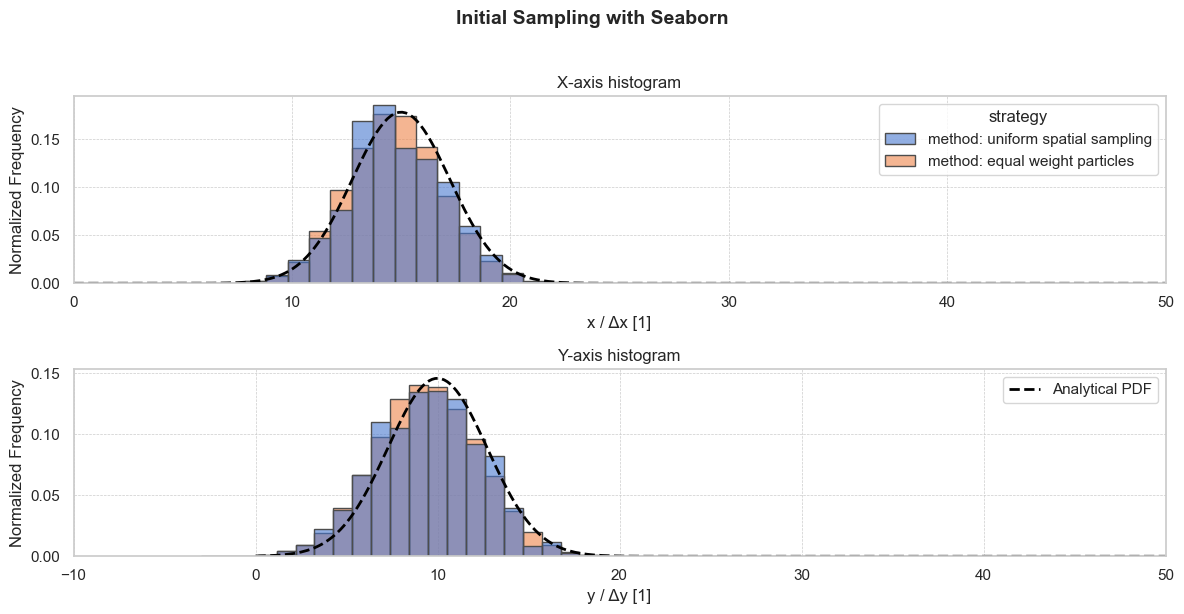

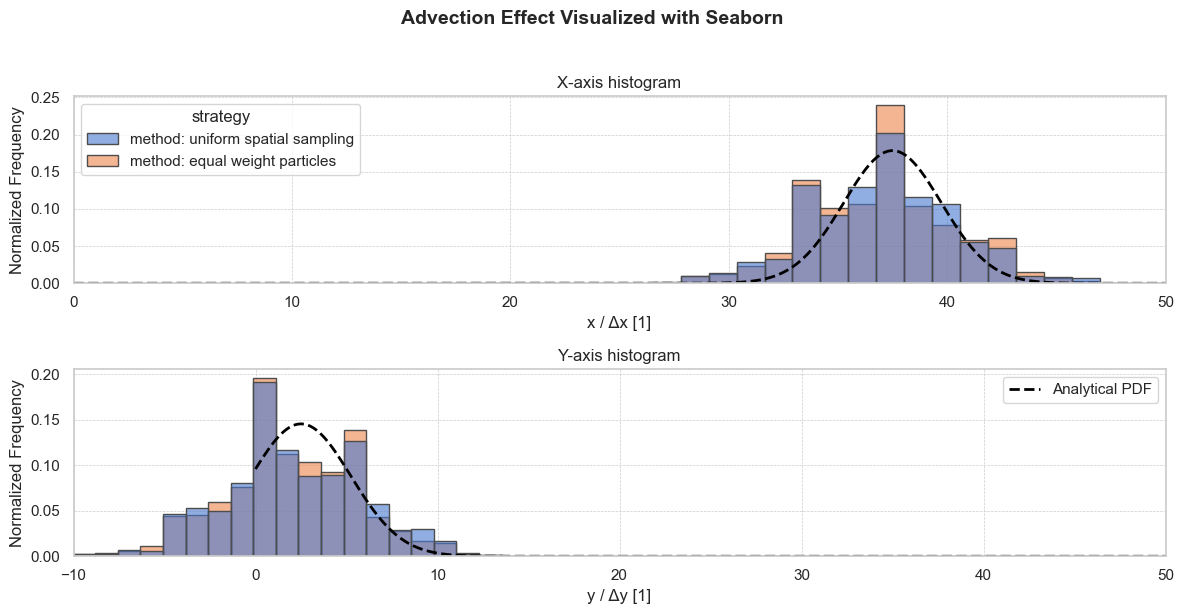

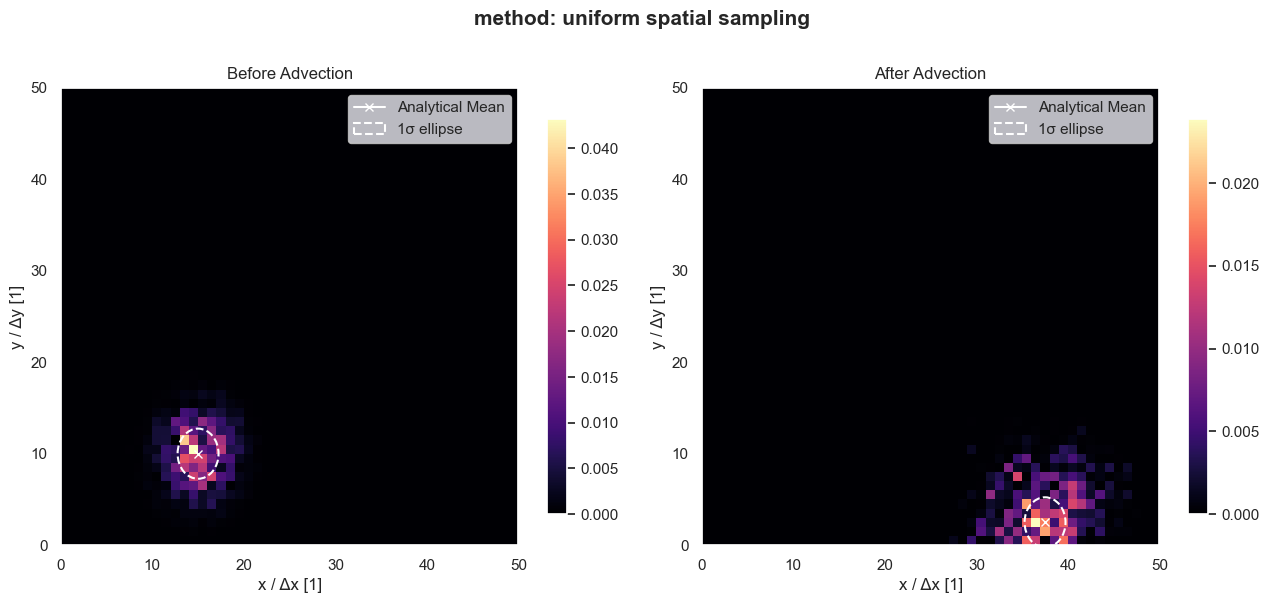

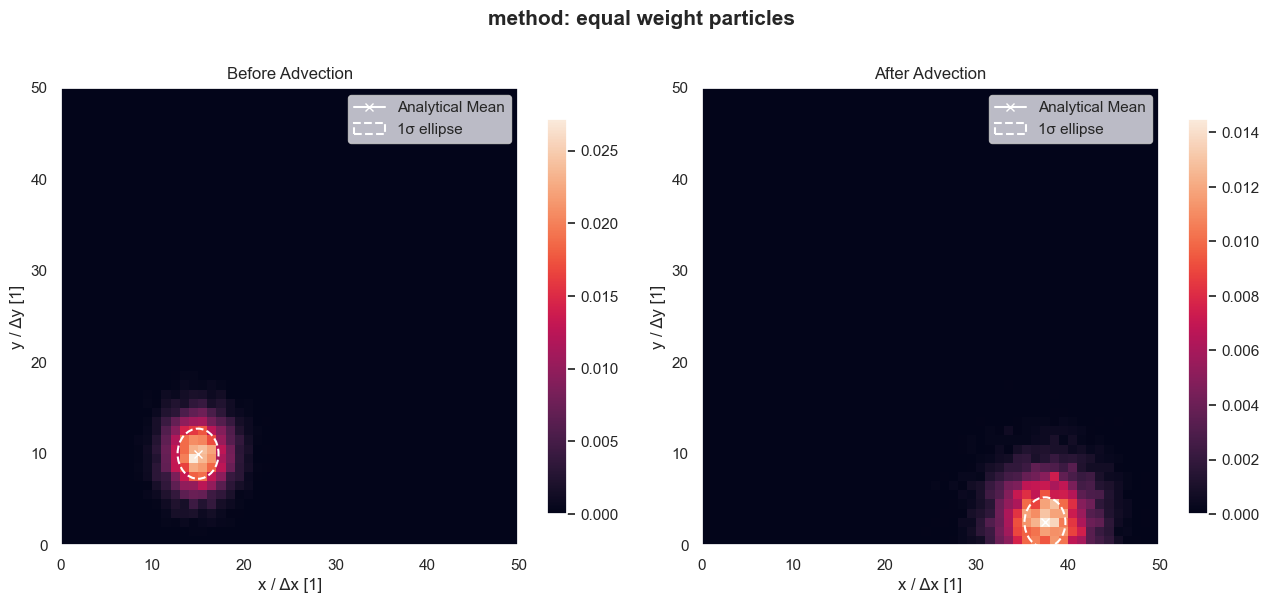

In [12]:
def visualize_projections_seaborn(
    particle_sets: dict[str, ParticleState],
    offset: tuple[float, float] = (0.0, 0.0),
    *,
    main_title: str | None = None,
) -> None:
    """
    Displays stylized histograms using Seaborn for better appearance.
    """
    sns.set_theme(style="whitegrid", palette="muted")
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=False)

    if main_title:
        fig.suptitle(main_title, fontsize=14, weight="bold", y=1.02)

    axes_titles = ["X-axis histogram", "Y-axis histogram"]

    for idx, ax in enumerate(axes):
        # Analytic PDF
        x_vals = np.linspace(0, GRID_DEF.size[idx], 300)
        pdf = PARTICLE_DEF.extract_axis_distribution(idx).pdf(x_vals - offset[idx]) * GRID_DEF.resolution[idx]
        ax.plot(x_vals / GRID_DEF.resolution[idx], pdf, color="black", lw=2, linestyle="--", label="Analytical PDF")

        # Prepare seaborn-friendly DataFrame
        df_all = pd.DataFrame(columns=["position", "strategy"])
        for label, dataset in particle_sets.items():
            positions = dataset.indices[:, idx]
            weights = dataset.weights / PARTICLE_DEF.magnitude
            temp_df = pd.DataFrame({
                "position": positions,
                "strategy": label,
                "weight": weights
            })
            df_all = pd.concat([df_all, temp_df], ignore_index=True)

        # Plot histogram using seaborn
        sns.histplot(
            data=df_all,
            x="position",
            hue="strategy",
            weights="weight",
            bins=GRID_DEF.divisions[idx],
            multiple="layer",
            edgecolor="0.3",
            alpha=0.6,
            ax=ax
        )

        ax.set_title(axes_titles[idx])
        ax.set_xlabel(f"{['x', 'y'][idx]} / Δ{['x', 'y'][idx]} [1]")
        ax.set_ylabel("Normalized Frequency")
        ax.set_xlim(0, GRID_DEF.divisions[idx])
        ax.grid(True, linestyle="--", linewidth=0.5)

    plt.xlim(-10, 50)
    plt.tight_layout()
    plt.legend()
    plt.show()

visualize_projections_seaborn(
    PARTICLE_SETS,
    main_title="Initial Sampling with Seaborn"
)

visualize_projections_seaborn(
    ADVECTED_PARTICLES,
    offset=tuple(TIME_DEF.flow_vector * TIME_DEF.total_duration),
    main_title="Advection Effect Visualized with Seaborn",
)

def render_2d_density_maps_styled() -> None:
    """
    Displays styled 2D histograms of particle distributions before and after advection.
    """
    sns.set_theme(style="darkgrid") 

    colormaps = {
        "equal": "rocket",
        "random": "viridis",
        "default": "magma",
    }

    for label in PARTICLE_SETS.keys():
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))
        fig.suptitle(f"{label}", fontsize=15, fontweight="bold")

        dist_x = PARTICLE_DEF.extract_axis_distribution(0)
        dist_y = PARTICLE_DEF.extract_axis_distribution(1)

        for i, (state, drift) in enumerate(zip(
            [PARTICLE_SETS[label], ADVECTED_PARTICLES[label]],
            [(0.0, 0.0), tuple(TIME_DEF.flow_vector * TIME_DEF.total_duration)],
        )):
            mean_xy = np.array([dist_x.mean(), dist_y.mean()]) + drift
            std_xy = np.array([dist_x.std(), dist_y.std()])

            mean_idx = mean_xy / GRID_DEF.resolution
            std_idx = std_xy / GRID_DEF.resolution

            ax = axes[i]
            ax.set_title("Before Advection" if i == 0 else "After Advection", fontsize=12)
            ax.set_xlabel("x / Δx [1]")
            ax.set_ylabel("y / Δy [1]")

            cmap_key = "equal" if "equal" in label else ("random" if "random" in label else "default")
            cmap = colormaps[cmap_key]

            hist = ax.hist2d(
                x=state.indices[:, 0],
                y=state.indices[:, 1],
                weights=state.weights / PARTICLE_DEF.magnitude,
                bins=GRID_DEF.divisions,
                range=[[0, GRID_DEF.divisions[0]], [0, GRID_DEF.divisions[1]]],
                cmap=cmap,
            )
            fig.colorbar(hist[3], ax=ax, shrink=0.75)

            # Środek rozkładu
            ax.plot(*mean_idx, marker="x", color="white", markersize=6, label="Analytical Mean")

            # Elipsa 1σ
            ellipse = patches.Ellipse(
                xy=mean_idx,
                width=2 * std_idx[0],
                height=2 * std_idx[1],
                edgecolor="white",
                facecolor="none",
                linestyle="--",
                linewidth=1.5,
                label="1σ ellipse",
            )
            ax.add_patch(ellipse)

            ax.set_aspect("equal")
            ax.grid(True, linestyle="--", alpha=0.3)
            ax.set_xlim(0, GRID_DEF.divisions[0])
            ax.set_ylim(0, GRID_DEF.divisions[1])
            ax.legend(loc="upper right")

        plt.tight_layout()
        plt.show()
render_2d_density_maps_styled()

### Conclusions
The Monte Carlo model accurately simulates advection with constant velocity, reproducing a linear shift of the particle distribution without deformation; the results align with the analytical solution, as the initial distribution is displaced by the product of velocity and time; the sampling strategy influences particle dispersion after advection, with the constant multiplicity method producing a more concentrated distribution than uniform spatial sampling.









